In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit
from scipy.stats import entropy

from mne.decoding import CSP

current_directory = os.path.abspath('')

project_root = os.path.abspath(os.path.join(current_directory, '..'))

sys.path.append(project_root)

print("ROOT:", project_root)
from Early_predict_UQ.data.make_dataset import make_data
from Early_predict_UQ.data.plots import plot_accuracy_over_time_and_epochs, plot_confidence_over_time_and_epochs, plot_entropy_over_time_and_epochs, plot_probabilities_over_time_and_epochs

#from feauterimport plot_entropy_over_time

#add for when only 1 epoch

def predict_expanding(initial_window_length, w_start, w_step, y_test, epochs_data, test_idx, probs_this_window, chosen_epoch = None):
    score_this_window = []
    #preds_this_window = []
    entropy_this_window = []
    confidence_this_window = []
    for n, window_start in enumerate(w_start):
        window_length = initial_window_length + n * w_step
        X_test  = csp.transform(epochs_data[test_idx][:, :, window_start:(window_start + window_length)])
        #print("X_test  shape:\n",X_test.shape)
        if chosen_epoch != None:
            X_test = X_test [chosen_epoch] #Chooosing a specific epoch in the test set 
        #Accuracy
        score = lda.score(X_test, y_test)
        score_this_window.append(score)
        
        probabilities = lda.predict_proba(X_test)
        
        if len(probs_this_window) == 0:
            probs_this_window = probabilities
        else:
            probs_this_window = np.vstack((probs_this_window, probabilities))

       # print("Prediction for this time window: ", prediction)
        #print("prob shape: ", probabilities.shape)
        #print("probabilities: \n", probabilities)

        #predictive entropy - H_pred(p) 
        entropy_score = entropy(probabilities, axis = 1) #- see if entropy is better than probabilites
        entropy_this_window.append(entropy_score)

        '''
        Confidence - as seen in: 
        Uncertainty Quantification in Machine Learning for Biosignal Applications - A Review, page 13.
        1 - H_pred(p) can be used as a confidence measure. Normalizing seems useful - 1 / (1- entropy-score)
        '''
        #confidence
        confidence = 1 - entropy_score
        confidence_this_window.append(confidence)

    return score_this_window, probs_this_window, entropy_this_window, confidence_this_window


#def predict_sliding():
    
threshold = 0.7
subject_list = [1]

# Preprocessed epochs
epochs, labels = make_data(subject_list)


# Asserting the epochs and labels (last row of the events matrix) to be used for the classification
epochs_train = epochs.copy()
labels = epochs.events[:, -1] - 4

# Cross validation 
## (Might need to do cross session - session 1 as train, and session 2 as test. See dataset_structure.ipynb)
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(2, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# LDA and CSP pipeline
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Class balance between the 4 classes. 
class_balance = np.zeros(4)
for i in range(4):
    class_balance[i] = np.mean(labels == i)

class_balance = np.max(class_balance)

sfreq = 250 # Sampling frequency of 250 Hz as per the BCI competion dataset 2a

# Classify the signal using a sliding window or expanding window
w_length = int(sfreq * 0.5)  # Window length/initial window length
w_step = int(sfreq * 0.1)  # window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step) #
print("w start shape: ", w_start.shape)

class_names = {
        1: "Left hand",
        2: "Right hand",
        3: "Both feet",
        4: "Tongue"
}

probabilities_windows = []
scores_windows = []  
confidence_windows = []
entropy_windows = []
traversal_type = 'expanding'
c= 0
# Running classification across the signal
for train_idx, test_idx in cv_split:
    c += 1
    y_train, y_test = labels[train_idx], labels[test_idx] # Get the current labels and data
    
    # Exatract spatial filters and transform the data as a whole
    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # Fit the classifier on the training data
    lda.fit(X_train, y_train)
    w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

    # Test the classifier on the windows. This is where we run over the signal
    probs_this_window = []
    #chosen_epoch = 80
    if traversal_type == 'sliding':
        traversal_type = 'sliding'
        #predict_sliding()
    else:
        #traversal_type == 'expanding'
        score_this_window, probs_this_window, entropy_this_window, confidence_this_window = predict_expanding(
            w_length, 
            w_start,
            w_step,
            y_test,
            epochs_data,
            test_idx,
            probs_this_window,
            chosen_epoch = None
        )

    if c == 1:
        print(probs_this_window)
        probabilities_windows = np.mean(probs_this_window, 0)
        print(probs_this_window.shape)
    else:
        probabilities_windows = np.vstack((probabilities_windows,  np.mean(probs_this_window)))

    scores_windows.append(score_this_window)
    confidence_windows.append(confidence_this_window)
    entropy_windows.append(entropy_this_window)


Choosing from all possible events


ROOT: c:\Users\Eier\Documents\UNI\Bachelor_thesis\UQ_Early_prediction_MI_BCI
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequen

c:\Users\Eier\miniconda3\envs\mne\Lib\site-packages\moabb\paradigms\base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 3041 task

w start shape:  (36,)
Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 22 dim * 6.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 22 dim * 6.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 1

accuracy_all shape:  2
confindence_all shape:  2
probs:  [[2.27484369e-01 4.78495557e-01 2.90366161e-01 3.65391332e-03]
 [5.53373670e-04 5.84723043e-04 2.77623541e-01 7.21238363e-01]
 [9.25157351e-01 5.95069238e-02 1.51084287e-02 2.27296207e-04]
 ...
 [9.39030329e-01 2.79986092e-03 1.91998867e-02 3.89699237e-02]
 [9.97233897e-01 3.35010746e-05 2.00658167e-03 7.26020457e-04]
 [3.32319081e-01 5.18965482e-01 1.47008104e-01 1.70733249e-03]]


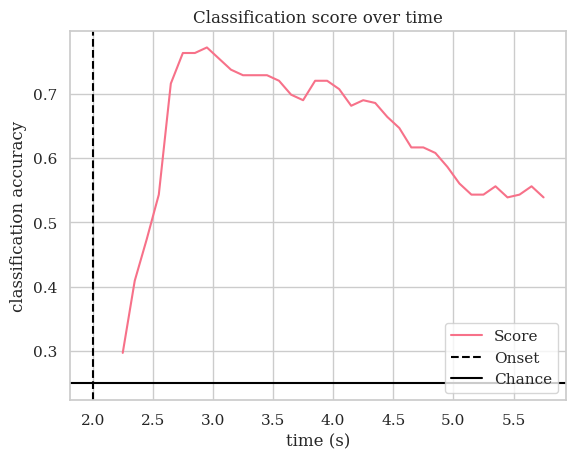

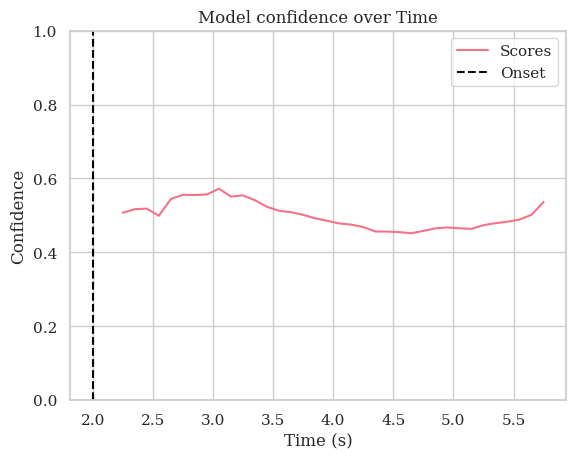

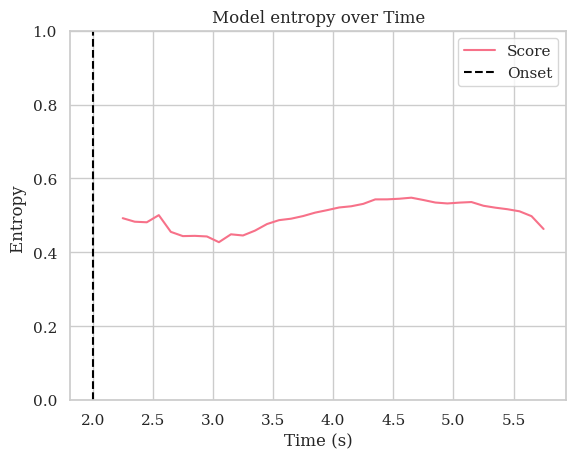

ValueError: x and y must have same first dimension, but have shapes (36,) and (8352,)

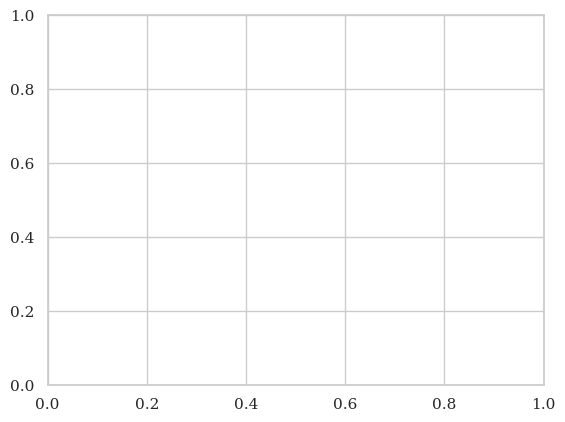

In [ ]:
# Plot the scores over time
print("accuracy_all shape: ", len(scores_windows))
print("confindence_all shape: ", len(confidence_windows))
print("probs: ", probabilities_windows)
plot_accuracy_over_time_and_epochs(w_times, scores_windows, class_balance)
plot_confidence_over_time_and_epochs(w_times, np.mean(confidence_windows, 0).T, threshold)
plot_entropy_over_time_and_epochs(w_times, np.mean(entropy_windows, 0).T)
plot_probabilities_over_time_and_epochs(w_times, probabilities_windows, threshold, class_names)



Choosing from all possible events


ROOT: /workspaces/UQ_Early_prediction_MI_BCI
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied



CV FOR: expanding
Computing rank from data with rank=None
    Using tolerance 3.3e-05 (2.2e-16 eps * 22 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)
/tmp/ipykernel_91248/3832665514.py:141: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  w_start = np.arange(0, epochs.get_data().shape[2] - w_length, w_step)
/tmp/ipykernel_91248/3832665514.py:171: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  cv_split = cv.split(epochs_train.get_data())
/tmp/ipykernel_91248/3832665514.py:179: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train.get_data()[train_idx], y_train)


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
EXPANDING METHOD
sorted probabilities: 
 [0.99

/tmp/ipykernel_91248/3832665514.py:180: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_test = csp.transform(epochs_train.get_data()[test_idx])
/tmp/ipykernel_91248/3832665514.py:211: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data(),
/tmp/ipykernel_91248/3832665514.py:179: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train.get_data()[train_idx], y_train)


    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

/tmp/ipykernel_91248/3832665514.py:180: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_test = csp.transform(epochs_train.get_data()[test_idx])
/tmp/ipykernel_91248/3832665514.py:211: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data(),
/tmp/ipykernel_91248/3832665514.py:179: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train.get_data()[train_idx], y_train)


    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e-05 (2.2e-16 eps * 22 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: ra

/tmp/ipykernel_91248/3832665514.py:180: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_test = csp.transform(epochs_train.get_data()[test_idx])
/tmp/ipykernel_91248/3832665514.py:211: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data(),
/tmp/ipykernel_91248/3832665514.py:179: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train.get_data()[train_idx], y_train)


    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

/tmp/ipykernel_91248/3832665514.py:180: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_test = csp.transform(epochs_train.get_data()[test_idx])
/tmp/ipykernel_91248/3832665514.py:211: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data(),
/tmp/ipykernel_91248/3832665514.py:179: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train.get_data()[train_idx], y_train)


    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

/tmp/ipykernel_91248/3832665514.py:180: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_test = csp.transform(epochs_train.get_data()[test_idx])
/tmp/ipykernel_91248/3832665514.py:211: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data(),


EXPANDING METHOD
sorted probabilities: 
 [0.9995655288946239, 0.9992976763401169, 0.9987791243592012, 0.9968012932975485, 0.9964920372646258, 0.9920785148148704, 0.9896793685243018, 0.9894232954077314, 0.9892074941483593, 0.9864944541532649, 0.9864202450585385, 0.9861728233448884, 0.9841581510540123, 0.9829917489634117, 0.9825948034555169, 0.9817003878964351, 0.9808225151696048, 0.9800846207532665, 0.974676780189301, 0.9713080081611878, 0.9668705470215319, 0.966763472412161, 0.9617331598459716, 0.9487895043360793, 0.9425791586700619, 0.9417853725835864, 0.9404019825786167, 0.9375614996663973, 0.936897003528594, 0.9353610073266672, 0.9352405902509336, 0.9350082536049654, 0.9341619618769806, 0.9305743446765394, 0.9204190138348931, 0.9186347255450752, 0.9185395252136229, 0.916545827795579, 0.9119713343326088, 0.9104452583944503, 0.9099605036822914, 0.9026689017223143, 0.8760797538575531, 0.8733266953702836, 0.8717800301485157, 0.8688017895095136, 0.8594478412544158, 0.8538749582117069, 0.

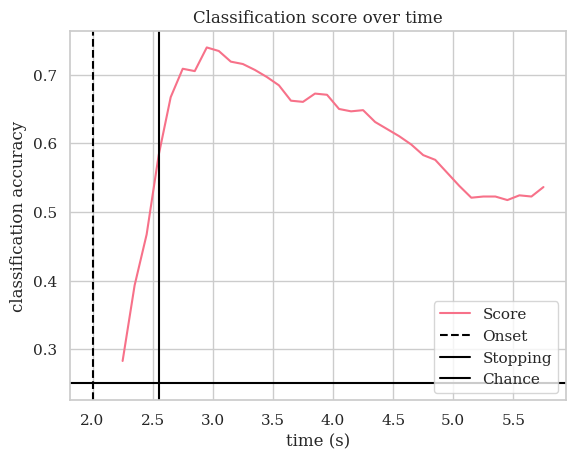

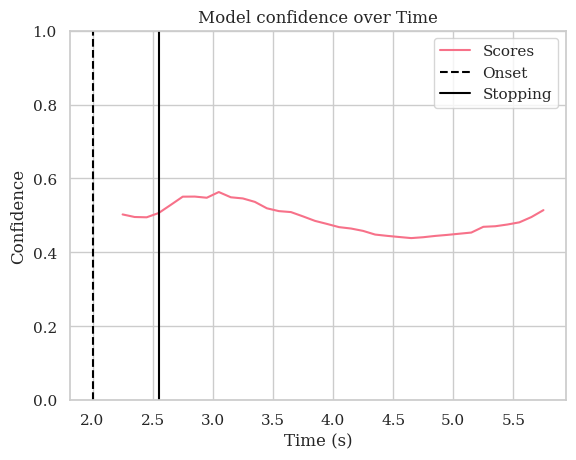




CV FOR: sliding
Computing rank from data with rank=None
    Using tolerance 3.3e-05 (2.2e-16 eps * 22 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


/tmp/ipykernel_91248/3832665514.py:171: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  cv_split = cv.split(epochs_train.get_data())
/tmp/ipykernel_91248/3832665514.py:179: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train.get_data()[train_idx], y_train)


Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
SLIDING METHOD
Score_this_window sliding, mean:
 0.573515325670498



CV FOR: sliding
Computing rank from data with rank=No

/tmp/ipykernel_91248/3832665514.py:180: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_test = csp.transform(epochs_train.get_data()[test_idx])
/tmp/ipykernel_91248/3832665514.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data(),
/tmp/ipykernel_91248/3832665514.py:179: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train.get_data()[train_idx], y_train)


    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

/tmp/ipykernel_91248/3832665514.py:180: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_test = csp.transform(epochs_train.get_data()[test_idx])
/tmp/ipykernel_91248/3832665514.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data(),
/tmp/ipykernel_91248/3832665514.py:179: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train.get_data()[train_idx], y_train)


    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e-05 (2.2e-16 eps * 22 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: ra

/tmp/ipykernel_91248/3832665514.py:180: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_test = csp.transform(epochs_train.get_data()[test_idx])
/tmp/ipykernel_91248/3832665514.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data(),
/tmp/ipykernel_91248/3832665514.py:179: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train.get_data()[train_idx], y_train)


    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

/tmp/ipykernel_91248/3832665514.py:180: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_test = csp.transform(epochs_train.get_data()[test_idx])
/tmp/ipykernel_91248/3832665514.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data(),
/tmp/ipykernel_91248/3832665514.py:179: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = csp.fit_transform(epochs_train.get_data()[train_idx], y_train)


    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

/tmp/ipykernel_91248/3832665514.py:180: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_test = csp.transform(epochs_train.get_data()[test_idx])
/tmp/ipykernel_91248/3832665514.py:197: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data(),


SLIDING METHOD
Score_this_window sliding, mean:
 0.5624999999999999
Scores.shape:
 (5, 36)
w times:
 (36,)



END OF: sliding


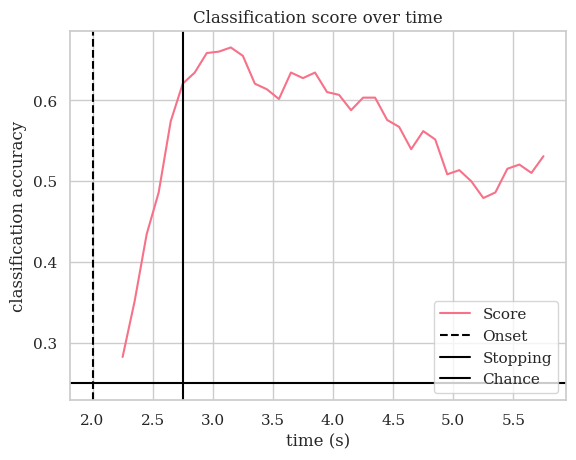

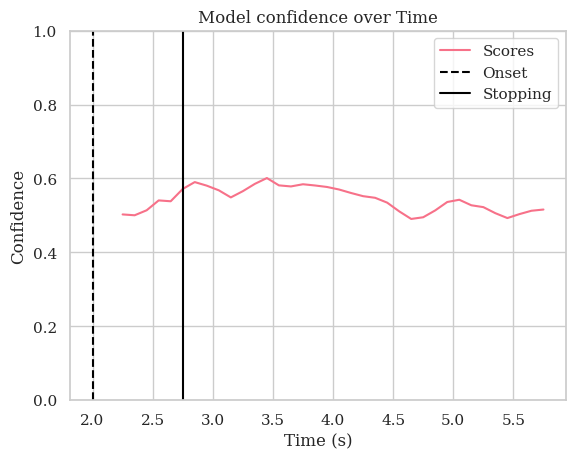

WHOLE DATA METHOD
Computing rank from data with rank=None
    Using tolerance 3.3e-05 (2.2e-16 eps * 22 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL


/tmp/ipykernel_91248/3832665514.py:166: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  score_this_window = cross_val_score(clf, epochs_train.get_data(), labels, cv=cv, n_jobs=None)


Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from scipy.stats import entropy

from mne.decoding import CSP

current_directory = os.path.abspath('')

project_root = os.path.abspath(os.path.join(current_directory, '..'))

sys.path.append(project_root)

print("ROOT:", project_root)
from Early_predict_UQ.data.make_dataset import make_data
from Early_predict_UQ.data.plots import plot_accuracy_over_time_and_epochs, plot_confidence_over_time_and_epochs #, plot_cost_over_time_and_epochs


# predicting with an expanding window
def predict_expanding(initial_window_length, w_start, w_step, y_test, epochs_data, test_idx, probs_this_window, chosen_epoch=None):
    score_this_window = []
    entropy_this_window = []
    confidence_this_window = []
    costs = []
    numTimesBelowThreshold = 0
    numberOfNs = 0
    predict_time = 0
    predict = False
    for n, window_start in enumerate(w_start):
        window_length = initial_window_length + n * w_step
        X_test = csp.transform(epochs_data[test_idx][:, :, window_start:(window_start + window_length)])
        
        if chosen_epoch is not None:
            X_test = X_test[chosen_epoch]
        
        score = lda.score(X_test, y_test)
        score_this_window.append(score)
        
        probabilities = lda.predict_proba(X_test)
        
        if len(probs_this_window) == 0:
            probs_this_window = probabilities
        else:
            probs_this_window = np.vstack((probs_this_window, probabilities))

        #predictive entropy - H_pred(p) 
        entropy_score = entropy(probabilities, axis=1)
        entropy_this_window.append(entropy_score)

        '''
        Confidence - as seen in: 
        Uncertainty Quantification in Machine Learning for Biosignal Applications - A Review, page 13.
        1 - H_pred(p) can be used as a confidence measure. Normalizing seems useful - 1 / (1- entropy-score)
        '''
        confidence = 1 - entropy_score
        confidence_this_window.append(confidence)
        probabilities = np.array(probabilities)

        #Early prediction
        probabilities = probabilities.flatten()
        sorted_probs = sorted(probabilities, reverse=True)
        print("sorted probabilities: \n", sorted_probs)
        #cost1 = 1/(1+(sorted_probs[0] - sorted_probs[1]))
        cost =1/(1+(sorted_probs[0] + (sorted_probs[0] - sorted_probs[1])))
        costs.append(cost)
        if cost < 0.5 and predict == False:
            numTimesBelowThreshold +=1
            if numTimesBelowThreshold == 2:
                predict = True
                predict_time = numberOfNs
                print("BELOW")
        numberOfNs+=1

    return score_this_window, probs_this_window, entropy_this_window, confidence_this_window, predict_time, costs


# predicting with a sliding window
def predict_sliding(w_length, w_start, w_step, y_test, epochs_data, test_idx, probs_this_window, chosen_epoch=None):
    score_this_window = []
    entropy_this_window = []
    confidence_this_window = []
    
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])

        if chosen_epoch is not None:
            X_test = X_test[chosen_epoch]
        
        score = lda.score(X_test, y_test)
        score_this_window.append(score)
        
        probabilities = lda.predict_proba(X_test)
        
        if len(probs_this_window) == 0:
            probs_this_window = probabilities
        else:
            probs_this_window = np.vstack((probs_this_window, probabilities))

        entropy_score = entropy(probabilities, axis=1)
        entropy_this_window.append(entropy_score)

        confidence = 1 - entropy_score
        confidence_this_window.append(confidence)

    return score_this_window, probs_this_window, entropy_this_window, confidence_this_window

# Setting parameters
threshold = 0.7
subject_list = [1]


## (Might need to do cross session - session 1 as train, and session 2 as test. See dataset_structure.ipynb)
# load preprocessed epochs
epochs, labels = make_data(subject_list)

# Asserting the epochs and labels (last row of the events matrix) to be used for the classification
epochs_train = epochs.copy()
labels = epochs.events[:, -1] - 4

# Cross-validation 
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# LDA and CSP pipeline
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Class balance between the 4 classes
class_balance = np.max([np.mean(labels == i) for i in range(4)])

sfreq = 250  # Sampling frequency of 250 Hz, as per the BCI competion dataset 2a

# Classify the signal using a sliding window or expanding window
w_length = int(sfreq * 0.5)  # Window length/initial window length
w_step = int(sfreq * 0.1)  # Window step size
w_start = np.arange(0, epochs.get_data().shape[2] - w_length, w_step)
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

class_names = {
    1: "Left hand",
    2: "Right hand",
    3: "Both feet",
    4: "Tongue"
}

traversal_types = ['expanding', 'sliding', 'whole_data']
traversal_types_scores = []

# Loop through different traversal types
for traversal_type in traversal_types:
    probabilitites_windows = []
    scores_windows = []  
    confidence_windows = []
    entropy_windows = []
    predict_times = []
    
    # Handle the case of using the whole data
    if traversal_type == 'whole_data':
        print("WHOLE DATA METHOD")
        clf = Pipeline([("CSP", csp), ("LDA", lda)])
        score_this_window = cross_val_score(clf, epochs_train.get_data(), labels, cv=cv, n_jobs=None)
        print("Score_this_window whole, mean:\n",  np.mean(score_this_window))
    
    else:
        # Split data for cross-validation
        cv_split = cv.split(epochs_train.get_data())
        
        # Loop through cross-validation splits
        for train_idx, test_idx in cv_split:
            print("\n\n\nCV FOR:", traversal_type)
            y_train, y_test = labels[train_idx], labels[test_idx]
            
            # Transform data using CSP
            X_train = csp.fit_transform(epochs_train.get_data()[train_idx], y_train)
            X_test = csp.transform(epochs_train.get_data()[test_idx])
            
            # Fit classifier
            lda.fit(X_train, y_train)
            
            probs_this_window = []
            score_this_window = []
            confidence_this_window =  []
            
            # Predict based on traversal type
            if traversal_type == 'sliding':
                print("SLIDING METHOD")
                score_this_window, probs_this_window, entropy_this_window, confidence_this_window = predict_sliding(
                    w_length, 
                    w_start,
                    w_step,
                    y_test,
                    epochs.get_data(),
                    test_idx,
                    probs_this_window,
                    chosen_epoch=None
                )
                print("Score_this_window sliding, mean:\n", np.mean(score_this_window))
            #expanding window - hyperparamers - intial window lenght, expansion rate
            elif traversal_type == 'expanding':
                print("EXPANDING METHOD")
                score_this_window, probs_this_window, entropy_this_window, confidence_this_window, predict_time, costs = predict_expanding(
                    w_length, 
                    w_start,
                    w_step,
                    y_test,
                    epochs.get_data(),
                    test_idx,
                    probs_this_window,
                    chosen_epoch=None
                )
                print("Score_this_window expanding, mean:\n", np.mean(score_this_window))
            
            scores_windows.append(score_this_window)
            probabilitites_windows.append(probs_this_window)
            confidence_windows.append(np.mean(confidence_this_window, 1))
            entropy_windows.append(entropy_this_window)
            predict_times.append(predict_time)
            
            traversal_types_scores.append(np.mean(scores_windows))

        #print("Scores:\n", scores_windows)
        print("Scores.shape:\n", np.array(scores_windows).shape)
        print("w times:\n", np.array(w_times).shape)
        print("\n\n\nEND OF:", traversal_type)
        #cant plot in codespace
        #plot_cost_over_time_and_epochs(w_times, costs, predict_time)
        plot_accuracy_over_time_and_epochs(w_times, scores_windows, int(np.mean(predict_times)), class_balance)
        plot_confidence_over_time_and_epochs(w_times, confidence_windows, int(np.mean(predict_times)), threshold)

print(traversal_types_scores)

for i in range(len(traversal_types)):
    print(
        "Classification accuracy of %s: %f / Chance level: %f" % (traversal_types[i], traversal_types_scores[i], class_balance)
    )
''' In fix_csp_lda_current
To do: 
-  see if classification accuracy works and provides the right numbers
-  Plot costs with the average predict time (make it work for sliding and whole data too)
- start the hyperparameter tuning to maximize classification accuracy, and minimize predict_time 
- make it take into account all the subjects
- make it work using svm
- provide the plots for all the subjects for all subjects for each condition, let it just save the plots to a folder automatically
'''